# 🤒 Deep Q-learning for Epidemic Mitigation

## Importing the relevant packages

In [1]:
import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

from DQ_learning.model import DQN, DQN_Factorized
from DQ_learning.agent import Agent, ReplayMemory, DQNAgent, DQNAgent_Factorize

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
from itertools import count
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Environment

Loading the environment object and the environment, defining the action and observation spaces.

['Lausanne', 'Geneva', 'Sion', 'Neuchâtel', 'Basel', 'Bern', 'Lücern', 'St-Gallen', 'Zürich']


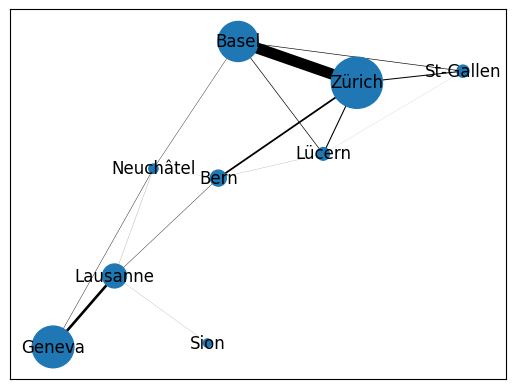

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.cities) # we added the encoding to ModelDynamics
dyn.draw_map()

sampled action : 4
Sampled observation


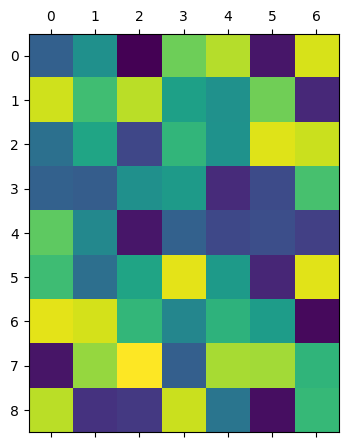

In [3]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[0,:,:])
plt.show()

In [4]:
SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead, confined))).unsqueeze(0)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

### Question 1.a) study the behavior of the model when epidemics are unmitigated.

Running the epidemic simulation for one episode (30 weeks), without epidemic mitigation (no action is
taken, i.e. all values in the action dictionary are set to False).

*Plots are below.*

In [5]:
""" Running the simulation """
log = []
finished = False
obs, info = env.reset(2)
while not finished:
    action = 0 # no action is taken = do nothing + no agent
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break
    
""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots:
Plot 1. A plot of variables $s^{[w]}_{total}$, $e^{[w]}_{total}$, $i^{[w]}_{total}$, $r^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the
variables share the y axis scaling.

Plot 2. A plot of variables $i^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the variables share the y axis scaling.

Plot 3. A set of plots of variables $i^{[w]}_{city}$, $d^{[w]}_{city}$ over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

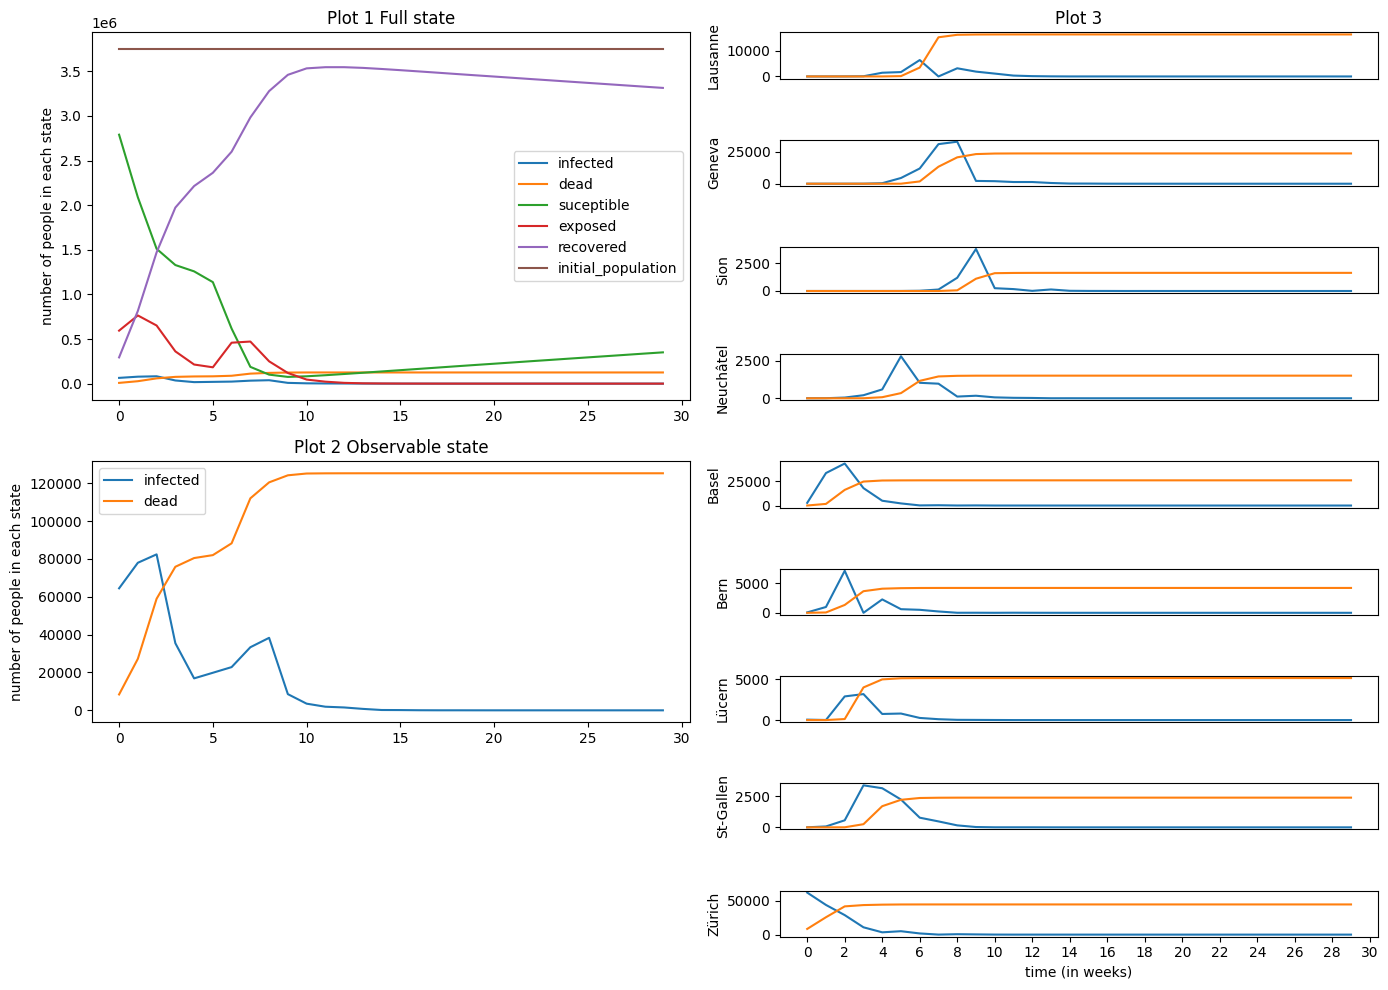

In [6]:
from matplotlib.ticker import MultipleLocator

# from the tutorial
def plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 3, 4]):
    fig = plt.figure(figsize=(14,10))
    if leftstate: 
        ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
        [ax_leftstate.plot(y) for y in total.values()] # log-lin
        ax_leftstate.legend(total.keys())
        ax_leftstate.set_title(f'Plot {order[0]} Full state')
        ax_leftstate.set_ylabel('number of people in each state')
        
    if leftobs:
        ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
        [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
        ax_leftobs.legend(['infected','dead'])
        ax_leftobs.set_title(f'Plot {order[1]} Observable state')
        ax_leftobs.set_ylabel('number of people in each state')
    
    if leftactions:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title(f'Plot {order[2]} Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')
                
    if right_per_city:
        ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
        ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
        ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}
        [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
        [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
        [ax.set_ylabel(c) for c, ax in ax_right.items()]
        [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
        ax_right['Zürich'].set_xlabel('time (in weeks)')
        ax_right['Lausanne'].set_title(f'Plot {order[3]}')
        ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()
    
plot_all(leftstate = True, leftobs =True, leftactions = False, right_per_city = True, order = [1, 2, 0, 3])

#### **Discussion**: 
When an agent does nothing to stop the disease from spreading the pandemic is likely to spread quickly and finish with a certain amount of deaths. That is what we can observe in the plots: the number of infected and exposed people in total has a peak at the beginning, which leads to increasing death (or recovery) numbers. This is precisely shown in the second and third plots from the infected and dead (infected -> 0 and dead -> constant). In the first plot, one can see an increase in susceptible people at the end of the simulation episode, which is due to the loss of immunity over time.

Notice: Initial population is fixed for the sake of correctness.

## Professor Russo’s Policy

### Question 2.a) Implement Pr. Russo’s Policy

Running the epidemic simulation for one episode(30 weeks) using Pr. Russo’s Policy to pick actions.

*Plots are below.*

In [7]:
# Implementation of Pr. Russo’s Policy (as a python class). 
class RussoAgent(Agent):
    def __init__(self,  env:Env):
        self.env = env
        self.count_confinement = 0
        self.dict = np.array([295000, 900000, 34978, 44531, 830000, 133115, 82000, 76213, 1354000]) 
        # dictionary for the population in each city
        # constant because the population in every city should be constant
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns an action
        total = np.sum(np.array(obs[0, 0, :, -1]) * self.dict)/SCALE # calculation of the total amount of infected people 
        if total >= 20000 and self.count_confinement == 0: # Russo's condition 
            self.count_confinement = 1
            return 1
        if self.count_confinement == 4:
            self.count_confinement = 0
        elif self.count_confinement != 0:
            self.count_confinement += 1
            return 1
        return 0

In [8]:
# running the simulation with Russo's agent
agent = RussoAgent(env)
log = []
finished = False
obs, info = env.reset(2)
agent.reset()
agent.epsilon = 0
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

#### Plots:
Plot 1. A plot of variables $s^{[w]}_{total}$, $e^{[w]}_{total}$, $i^{[w]}_{total}$, $r^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the
variables share the y axis scaling.

Plot 2. A plot of variables $i^{[w]}_{total}$, $d^{[w]}_{total}$ over time, where time is measured in weeks and all the variables share the y axis scaling.

Plot 3. A set of plots of variables $i^{[w]}_{city}$, $d^{[w]}_{city}$ over time, where time is measured in weeks (one subplot per-city, variables share the y-scaling per-city).

Plot 4. A plot of the action taken by the policy over time (whether the policy chooses to confine or not).

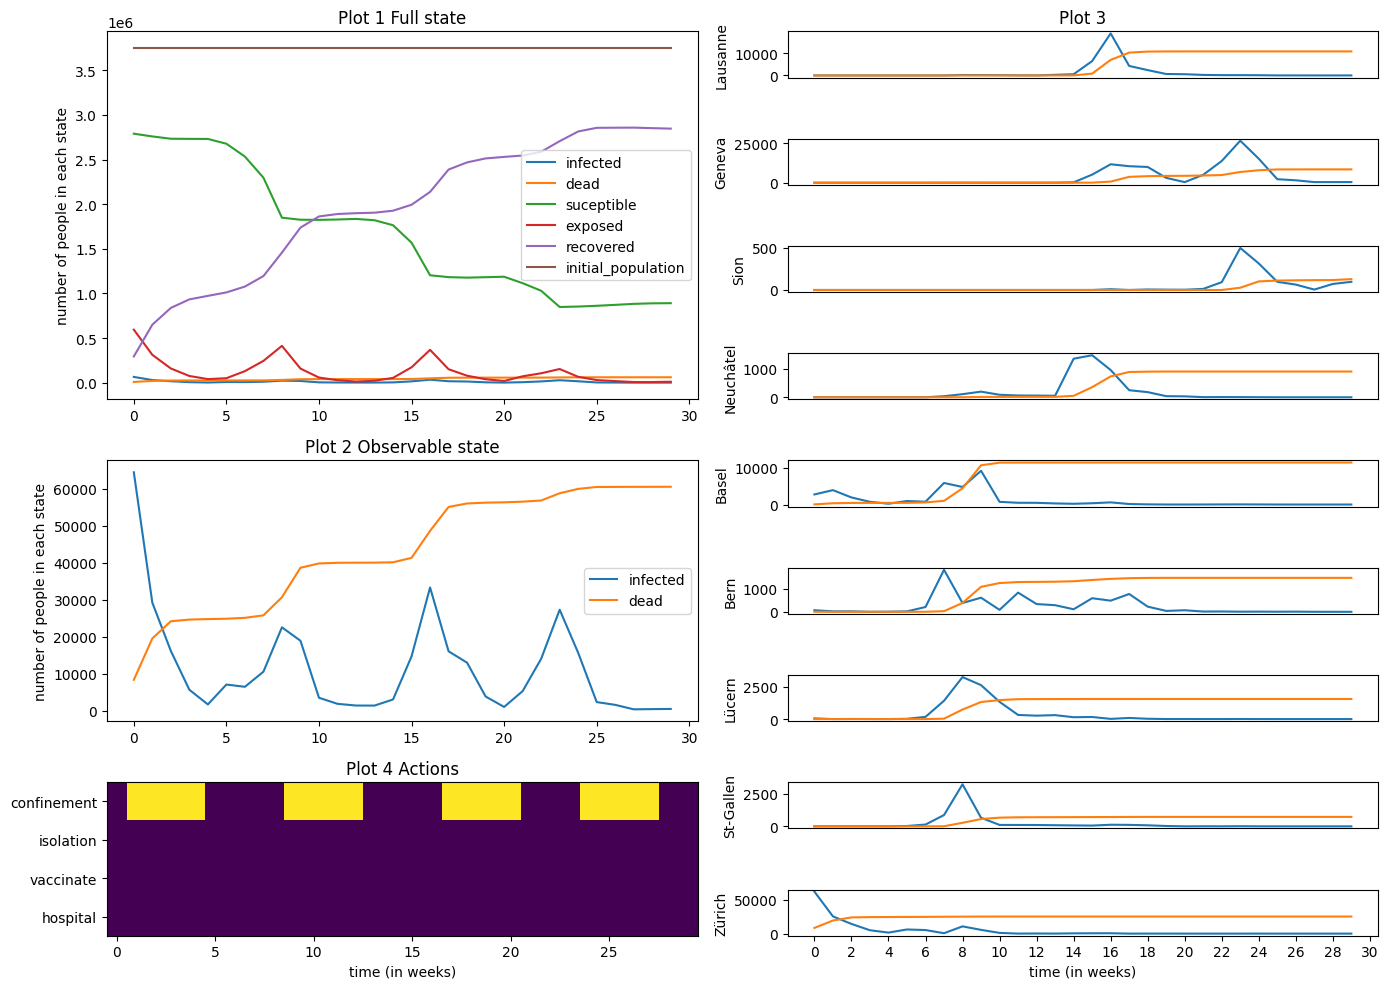

In [9]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

#### **Discussion**: 
Pr. Russo's Policy aims to reduce opportunities for the virus to spread and thus reduce the overall number of infections but periodically. 

Here we can observe the periodic increase and decrease of infected individuals in total for plots 1 and 2 and per city for plot 3 (Basel and Bern are the only cities where the boost of deaths was higher than for infections).

Also, the number of death decreased using Pr. Russo's Policy (60K) if compare to the first unmitigated scenario (120K). Over 30 weeks, the increase in death was mildly growing. However, in the unmitigated scenario, we saw a boost in the first 10 weeks.

Overall, Pr. Russo's Policy could potentially help mitigate the spread of an epidemic, but still, we need other important actions to be done such as vaccination.

### Question 2.b) Evaluate Pr. Russo’s Policy
Evaluation procedure: 
- run 50 simulation episodes where actions are chosen from Pr. Russo’s Policy 
- for each episode, save the following values:
    1. the number of total confined days $N_{confinement}$ = 7 · number of confined weeks,
    2. the cumulative reward (the sum of all rewards collected during the episode) $R_{cumulative} = \sum_{
i∈[0,...,30]} R[i]$.
    3. the number of total deaths $N_{deaths} = d^{[30]}_{total}$

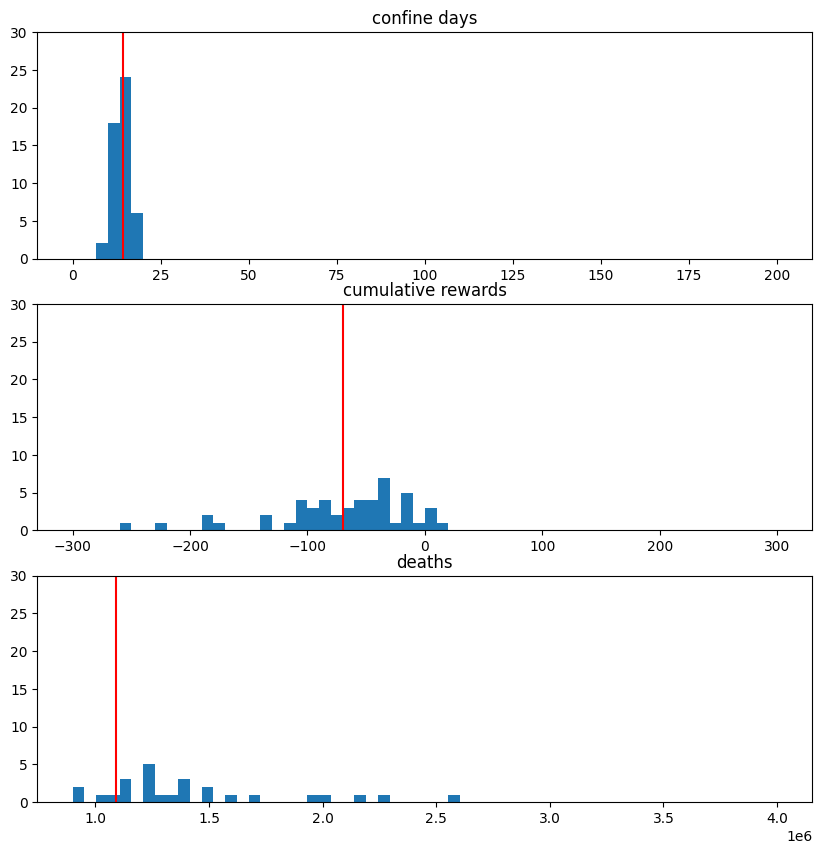

In [10]:
agent_russo = RussoAgent(env)

def hist_avg(ax, data, title):
    ymax = 30
    if title == 'deaths':
        x_range = (900000, 4000000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent, num_episodes):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    for trace in range(num_episodes):
        log = []
        seed = trace # dealing with sequence of random seeds
        finished = False
        obs, info = env.reset(seed)
        agent.reset()
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent.act(obs)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if action == 1:
                n_weeks_confined += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(n_weeks_confined) 
        rewards.append(R_sum)
        death.append(np.sum(total['dead']))
      
    hist_avg(ax[0], confine, "confine days")
    hist_avg(ax[1], rewards, "cumulative rewards")
    hist_avg(ax[2], death, "deaths")
run_experiment(agent_russo, 50)

## A Deep Q-learning approach

### Question 3.a) implementing Deep Q-Learning

Implementing and training the Deep Q-Learning agent $\pi_{DQN}$ for 500 training episodes, with $ϵ$ = 0.7.

*Plots of the training trace and the eval trace are below.*

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.pow(torch.Tensor(np.stack((infected, dead))).unsqueeze(0), 1/4)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [12]:
agent = DQNAgent(env, DQN)
log_eval = []
log_train = []
for train in range(3): #  three full training processe
  agent.reset() # reset agent 
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      R_total = 0
      state, info = env.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0: # (fully) update the target network every 5 episodes
          update_target = True
      for t in count():
          action = agent.act(state, i_episode)
          observation, reward, terminated, truncated = env.step(action.item())
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          # Store the transition in memory
          agent.memory.push(state, action, next_state, reward)
          # Move to the next state
          state = next_state
          # Perform one step of the optimization (on the policy network)
          agent.optimize_model(update_target)
          # Soft update of the target network's weights
          # θ′ ← τ θ + (1 −τ )θ′ let τ = 0.005
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # 20 episode evaluation procedure
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = 0
          agent.epsilon = 0 # stop exploration
          for i in range(20):
              state, info = env.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env.step(action.item())
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/3_a.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


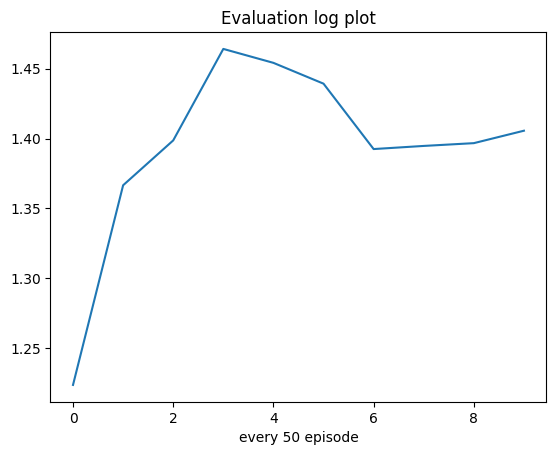

[1.2237936 1.3665663 1.3986534 1.4640722 1.454111  1.4392213 1.3924623
 1.3947014 1.3966866 1.4055835]


In [13]:
eval_log = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log)

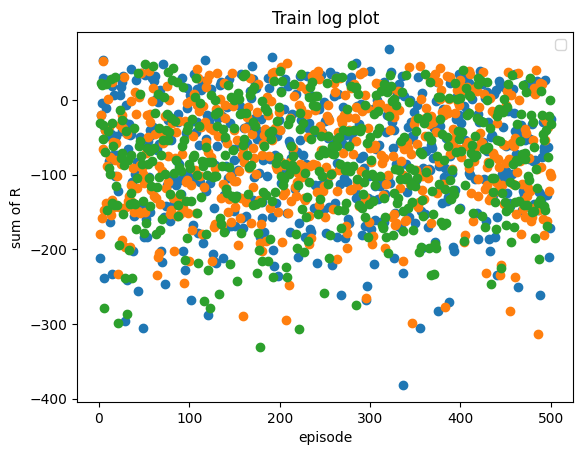

In [14]:
train_log = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log[0], x = np.arange(1, 501))
plt.scatter(y = train_log[1], x = np.arange(1, 501))
plt.scatter(y = train_log[2], x = np.arange(1, 501))
plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

**Does your agent learn a meaningful policy?**

An agent with epsilon = 0.7 acts randomly during its exploration phase, but doing so with such big epsilon is harmful to learning a meaningful policy if the agent continues to take actions based on mostly random experience.

That is what we can observe in the evaluation trace and training trace plots.

In [15]:
# Evaluation on best policy to plot the last episode
agent.load_model("/content/DQ_learning/models/3_a.pt")
log_eval = []
log = [] 
for i_episode in range(1, 4):
    print(i_episode)
    state, info = env.reset(i_episode)
    R_total = []
    agent.epsilon = 0
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env.step(action.item())
        if i_episode == 3:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

1
2
3


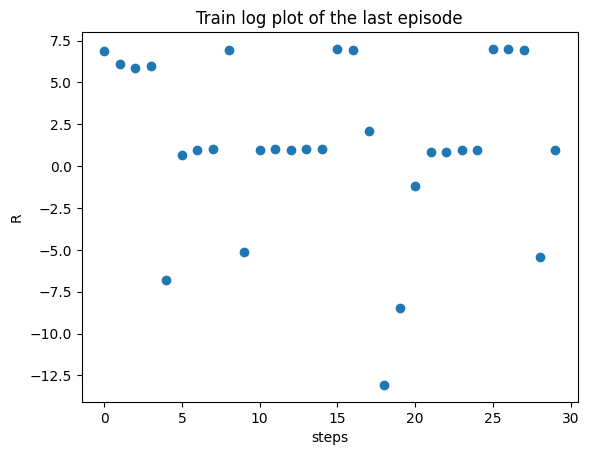

In [16]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

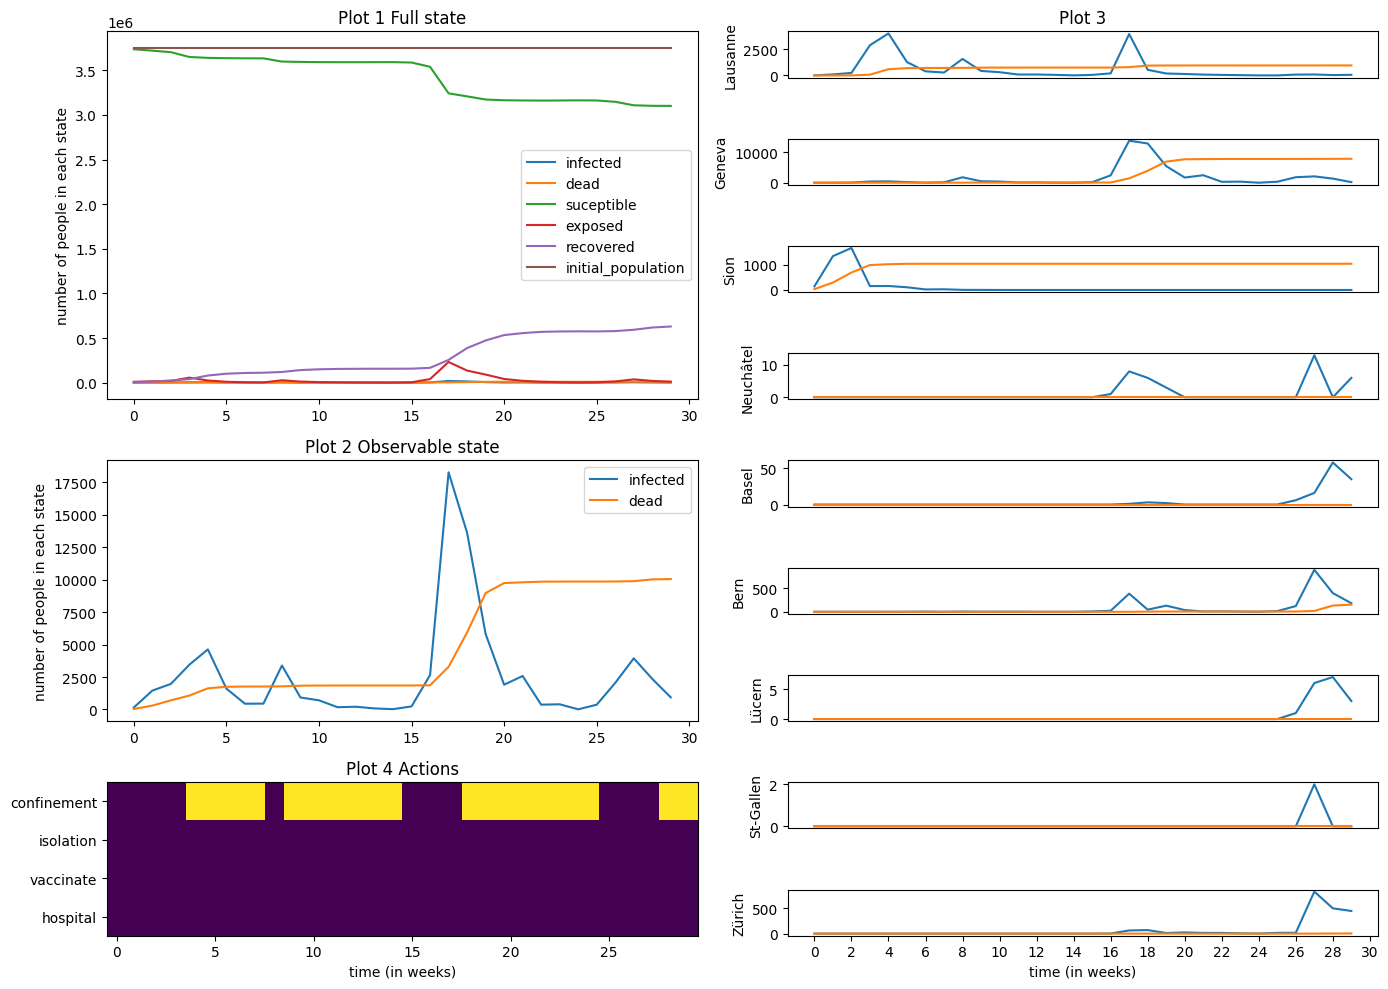

In [17]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

**Interpretation**

Here we can observe that as soon as the agent does nothing (no confinement) and the reward goes down with an increase of infected individuals, the agent does its action of confinement. 

It is shown in plot 4 of actions and on the train log plot of the last episode of the best policy we obtained.

### Question 3.b) decreasing exploration

Implementing and training Deep Q-Learning agent for 500 training episodes with decreasing $ϵ$.

*Plots of the training trace and the eval trace are below.*

In [18]:
agent = DQNAgent(env, DQN)
log_eval = []
log_train = []
decreasing = True
for train in range(3):
  agent.reset()
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      R_total = 0
      state, info = env.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0:
          update_target = True
      for t in count():
          action = agent.act(state, i_episode, decreasing)
          observation, reward, terminated, truncated = env.step(action.item())
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          agent.memory.push(state, action, next_state, reward)
          state = next_state
          agent.optimize_model(update_target)
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # Evaluation
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = 0
          agent.epsilon = 0
          for i in range(20):
              state, info = env.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env.step(action.item())
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/3_b.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


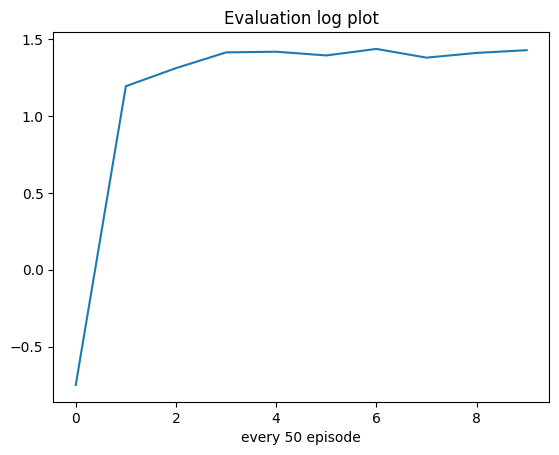

[-0.7490754  1.1940689  1.3116552  1.4140348  1.4184483  1.3942791
  1.4366446  1.3799562  1.4106747  1.4285668]


In [19]:
eval_log = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log)

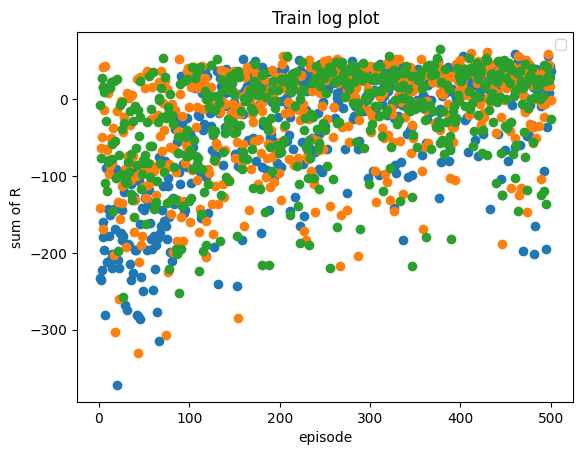

In [20]:
train_log = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log[0], x = np.arange(1, 501))
plt.scatter(y = train_log[1], x = np.arange(1, 501))
plt.scatter(y = train_log[2], x = np.arange(1, 501))
plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [21]:
# Evaluation on best policy to plot the last episode

agent.load_model("/content/DQ_learning/models/3_b.pt")
log_eval = []
log = []
for i_episode in range(1, 4):
    print(i_episode)
    state, info = env.reset(i_episode)
    R_total = []
    agent.epsilon = 0
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env.step(action.item())
        if i_episode == 3:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

1
2
3


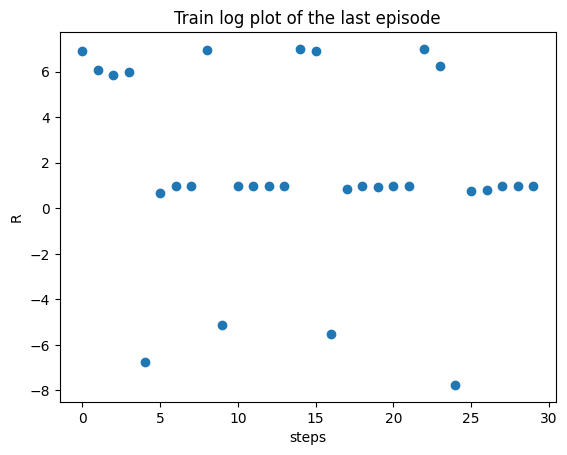

In [22]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

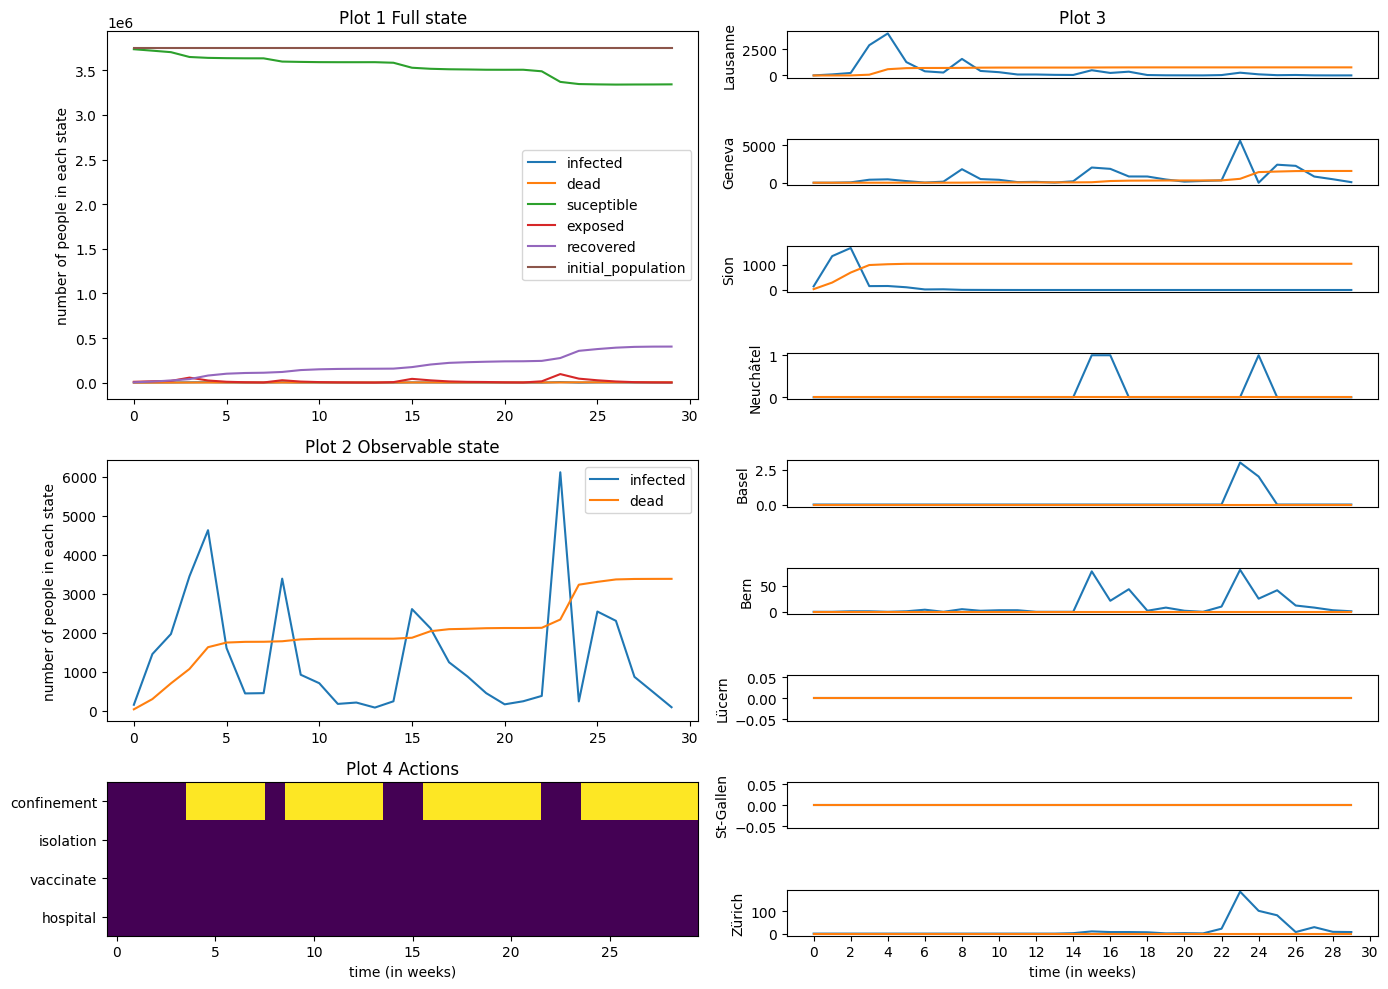

In [23]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

**Compare and discuss the results between questions 3.a) and 3.b). Which policy gets the best results and why?**

The difference between 3.a and 3.b can be distinguished from the train trace plot. The plot of 3.a is noisier because of the constant and huge exploration. The decreasing exploration policy can be better because with time we won't rely on random actions but only on those which increase a reward. On the evaluation trace plot, we see that the 3.b policy gives better results because of the reward boost. And one can see that the number of deaths is much smaller that in 3.a. 

To conclude, the result in 3.b is better than in 3.a.

### Question 3.c) evaluate the best performing policy against Pr. Russo’s policy
Running the best performing policy $\pi^{∗}_{DQN}$ through the evaluation code in 2.b), generating the same histogram plots and comparing the results.

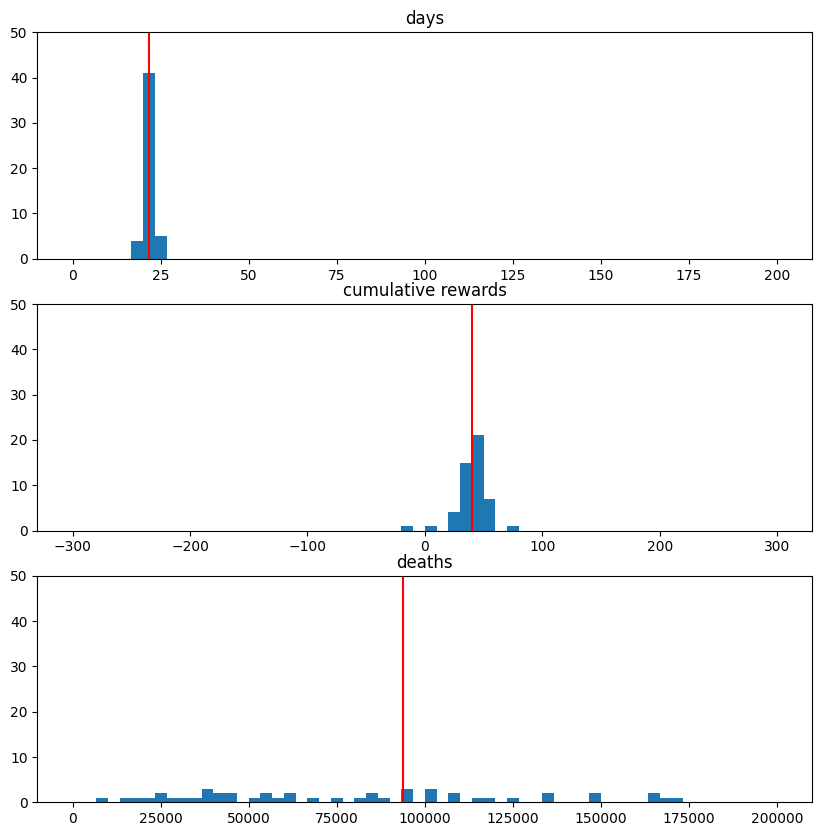

In [24]:
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (10,200000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent, num_episodes):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    for trace in range(num_episodes):
        log = []
        seed = trace
        finished = False
        obs, info = env.reset(seed)
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent.act(obs.flatten().unsqueeze(0), i_episode)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if action == 1:
                n_weeks_confined += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(n_weeks_confined) 
        rewards.append(R_sum)
        death.append(np.sum(total['dead']))
    hist_avg(ax[0], confine, "days")
    hist_avg(ax[1],rewards, "cumulative rewards")
    hist_avg(ax[2],death, "deaths")

agent.load_model("/content/DQ_learning/models/3_b.pt") 
run_experiment(agent, 50)

**Compare the results. Did the reinforcement learning policy outperform Pr. Russo’s, if so in what sense?**

Yes, because the average number of deaths is way smaller and the average cumulative rewards is way higher than when using Pr. Russo's policy. But the number of confined days is slightly bigger.

## Dealing with a more complex action Space

### Question 4.1.a) (Theory) Action space design

**Why would one want to use such an action-observation space as the one above, rather than directly compute Q(s, a) for each action? Discuss, the impact on network architecture and on training.**

Having such action space we might take several actions at the same time and not change the network output. But this can make the learning process slower and more unstable. 

The change of the observation space, which includes the current state of each action as an observation, enforce us to have a larger input layer size. 

### Question 4.1.b) Toggle-action-space multi-action policy training

Implementation of the toggled-action and observation spaces and training Deep Q-Learning agent on it. 

*Plots of the training and evaluation traces (we ask you to
average across 3 training runs) are below.*

In [11]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(3, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action_toggle = { # DO NOTHING
        'confinement': dyn.get_action()['confinement'], 
        'isolation': dyn.get_action()['isolation'], 
        'hospital': dyn.get_action()['hospital'], 
        'vaccinate': dyn.get_action()['vaccinate'],
    }

    if a == ACTION_CONFINE:
        action_toggle['confinement'] = not action_toggle['confinement']
    elif a == ACTION_ISOLATE:
        action_toggle['isolation'] = not action_toggle['isolation']
    elif a == ACTION_VACCINATE:
        action_toggle['vaccinate'] = not action_toggle['vaccinate']
    elif a == ACTION_HOSPITAL:
        action_toggle['hospital'] = not action_toggle['hospital']
    
    return action_toggle

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    obs_ = np.concatenate((
        np.ones((1, 7)) * int((dyn.get_action()['confinement'])),
        np.ones((1, 7)) * int((dyn.get_action()['isolation'])),
        np.ones((1, 7)) * int((dyn.get_action()['hospital'])),
        np.ones((1, 7)) * int((dyn.get_action()['vaccinate'])), 
        np.zeros((5, 7))
    )) 
    return torch.pow(torch.Tensor(np.stack((infected, dead, obs_))).unsqueeze(0), 1/4)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [12]:
agent = DQNAgent(env, DQN, lr = 1e-5)
log_eval = []
log_train = []
decreasing = True
for train in range(3):
  agent.reset()
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      R_total = 0
      state, info = env.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0:
          update_target = True
      for t in count():
          action = agent.act(state, i_episode, decreasing)
          observation, reward, terminated, truncated = env.step(action.item())
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          agent.memory.push(state, action, next_state, reward)
          state = next_state
          agent.optimize_model(update_target)
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # Evaluation
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = 0
          agent.epsilon = 0
          for i in range(20):
              state, info = env.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env.step(action.item())
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/4_1_b.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


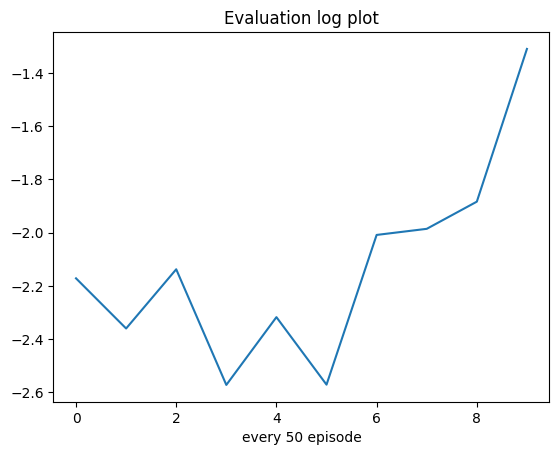

[-2.1717885 -2.3603833 -2.1377277 -2.5726225 -2.3177    -2.5715988
 -2.0085773 -1.9856386 -1.8834454 -1.3090566]


In [13]:
eval_log = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log)

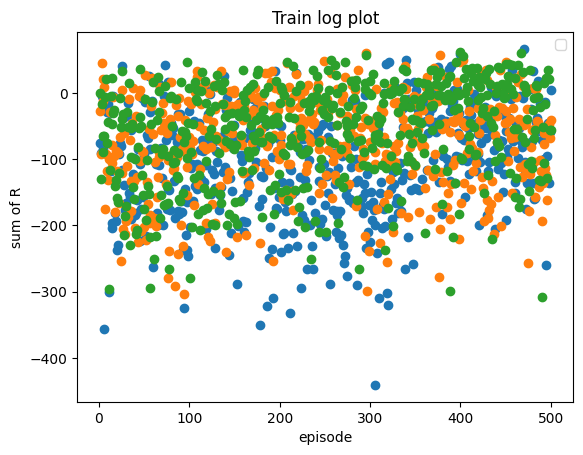

In [14]:
train_log = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log[0], x = np.arange(1, 501))
plt.scatter(y = train_log[1], x = np.arange(1, 501))
plt.scatter(y = train_log[2], x = np.arange(1, 501))
plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [16]:
agent.load_model("/content/DQ_learning/models/4_1_b.pt")
log_eval = []
log = []
for i_episode in range(1, 4):
    print(i_episode)
    state, info = env.reset(i_episode)
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    R_total = []
    agent.epsilon = 0
    state, info = env.reset()
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env.step(action.item())
        if i_episode == 3:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

1
2
3


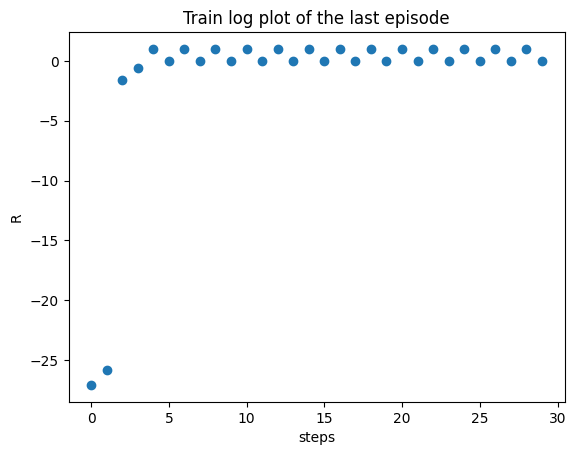

In [17]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

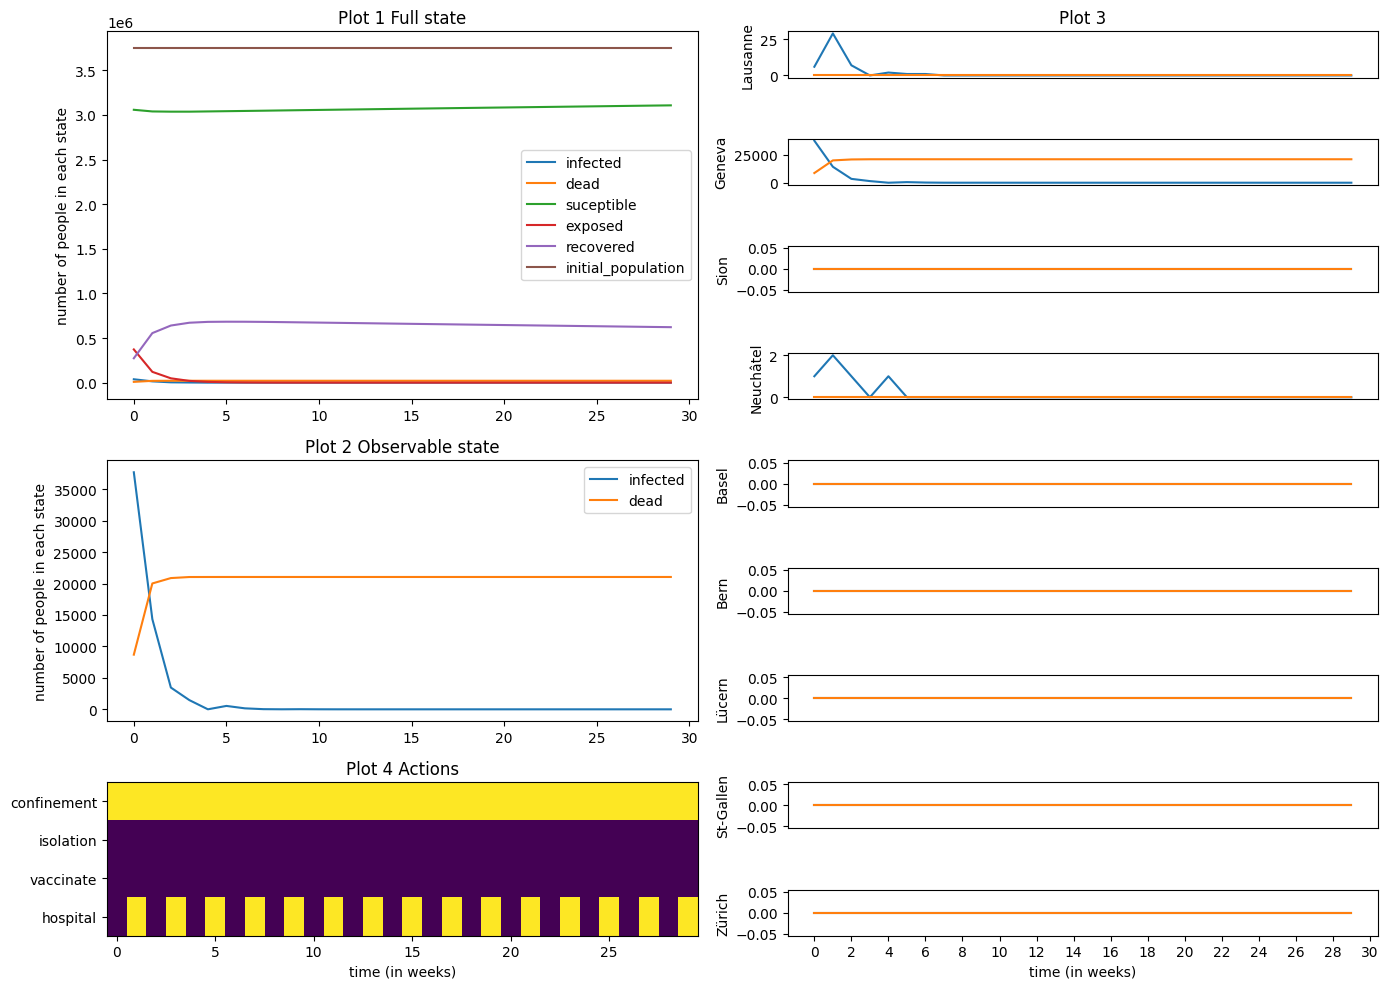

In [18]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

**Is the agent properly learning? Run a 3 episodes of the best policy $\pi^{∗}_{Toggle}$, to better understand the behavior of the learned policy. Interpret the policy.**

...............................................................................................


### Question 4.1.c) Toggle-action-space multi-action policy evaluation

Evaluation of the $\pi^{∗}_{Toggle}$ policy trained in question 4.1.b), using the evaluation procedure that you previously defined.

*Plot of the histograms are below*

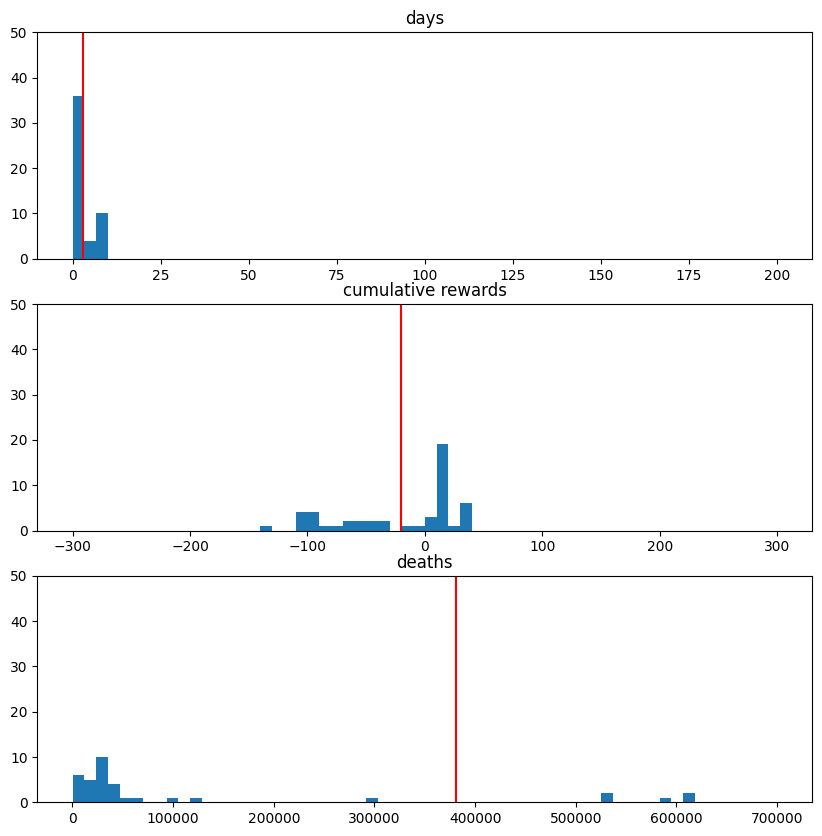

In [20]:
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (100,700000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent, num_episodes):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    for trace in range(num_episodes):
        log = []
        seed = trace
        finished = False
        obs, info = env.reset(seed)
        agent.reset()
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent.act(obs.flatten().unsqueeze(0), i_episode)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if action == 1:
                n_weeks_confined += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(n_weeks_confined) 
        rewards.append(R_sum)
        death.append(np.sum(total['dead']))
    hist_avg(ax[0], confine, "days")
    hist_avg(ax[1],rewards, "cumulative rewards")
    hist_avg(ax[2],death, "deaths")
    
run_experiment(agent, 50)

**How does the policy perform compared to the binary
action policy evaluated in question 3.c?**

..............................................................................................

### Question 4.1.d) (Theory) question about toggled-action-space policy, what assumption does it make?

**What assumptions does the use of such a technique make on the action space? Could you think of an action space for which toggling the actions would not be suitable? Discuss.**

...................................................................................................................................

### Question 4.2.a) multi-action factorized Q-values policy training

Implementation of the multi-action factorized Q-values agent and observation spaces and training Deep Q-Learning agent on it. 

*Plots of the evaluation and training traces on a graph together with the traces from the toggle-action-space training (averaged across 3 training runs).*
TOGETHER

In [25]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length), 
                                    dtype=np.float16)

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False,
        'isolation': False,
        'hospital': False,
        'vaccinate': False,
    }
    actions = []
    for i in range(len(a)):
      if a[i] == 1:
        actions.append(i)
    for i in actions:
        if i == ACTION_CONFINE:
            action['confinement'] = True
        elif i == ACTION_ISOLATE:
            action['isolation'] = True
        elif i == ACTION_VACCINATE:
            action['vaccinate'] = True
        elif i == ACTION_HOSPITAL:
            action['hospital'] = True
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.pow(torch.Tensor(np.stack((infected, dead))).unsqueeze(0), 1/4)

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

In [26]:
agent = DQNAgent_Factorize(env, DQN_Factorized, lr = 1e-5)
log_eval = []
log_train = []
decreasing = True
for train in range(3):
  agent.reset()
  print("Run:", train + 1)
  for i_episode in range(1, 501):
      R_total = 0
      state, info = env.reset(i_episode)
      state = state.flatten()
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
      update_target = False
      if i_episode%5 ==0:
          update_target = True
      for t in count():
          action = agent.act(state, i_episode, decreasing)
          observation, reward, terminated, truncated = env.step(action)
          R_total += reward[0][0]
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated
          if terminated:
              next_state = None
              break
          else:
              next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
          agent.memory.push(state, action.unsqueeze(0), next_state, reward)
          state = next_state
          agent.optimize_model(update_target)
          target_net_state_dict = agent.target_net.state_dict()
          policy_net_state_dict = agent.policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*0.005 + target_net_state_dict[key]*(1-0.005)
          agent.target_net.load_state_dict(target_net_state_dict)
      log_train.append(R_total)
      # Evaluation
      if i_episode%50 == 0:
          print(i_episode)
          R_total = []
          rewards = -100
          agent.epsilon = 0
          for i in range(20):
              state, info = env.reset(seed = i)
              state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
              for t in count():
                  action = agent.act(state, i_episode)
                  observation, reward, terminated, truncated = env.step(action)
                  R_total.append(reward[0][0])
                  reward = torch.tensor([reward], device=device)
                  done = terminated or truncated
                  if terminated:
                      next_state = None
                      break
                  else:
                      next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
                  state = next_state
          if np.mean(R_total) >= rewards:
              rewards = np.mean(R_total)
              # saving the best model
              agent.save_model("/content/DQ_learning/models/4_2_a.pt")
          agent.epsilon = 0.7
          log_eval.append(np.mean(R_total))

Run: 1
50
100
150
200
250
300
350
400
450
500
Run: 2
50
100
150
200
250
300
350
400
450
500
Run: 3
50
100
150
200
250
300
350
400
450
500


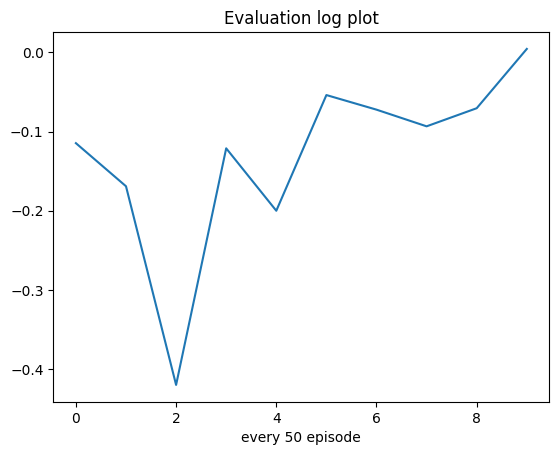

[-0.11462589 -0.16905795 -0.41998807 -0.12114099 -0.19999222 -0.05385822
 -0.07230216 -0.09335611 -0.07049425  0.00441054]


In [27]:
eval_log = np.array(log_eval).reshape(3, int(len(log_eval)/3)).mean(axis = 0)
plt.plot(eval_log)
plt.title("Evaluation log plot")
plt.xlabel("every 50 episode")
plt.show();
print(eval_log)

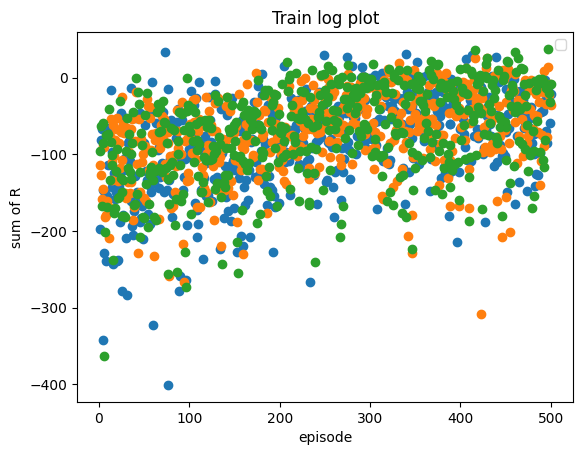

In [28]:
train_log = np.array(log_train).reshape(3, int(len(log_train)/3))
plt.scatter(y = train_log[0], x = np.arange(1, 501))
plt.scatter(y = train_log[1], x = np.arange(1, 501))
plt.scatter(y = train_log[2], x = np.arange(1, 501))
plt.legend()
plt.title("Train log plot")
plt.xlabel("episode")
plt.ylabel("sum of R")
plt.show();

In [29]:
agent.load_model("/content/DQ_learning/models/4_2_a.pt")
log_eval = []
log = []
for i_episode in range(1, 4):
    print(i_episode)
    state, info = env.reset(i_episode)
    state = state.flatten()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    R_total = []
    agent.epsilon = 0
    state, info = env.reset()
    state = torch.tensor(state.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = agent.act(state, i_episode)
        observation, reward, terminated, truncated = env.step(action)
        if i_episode == 3:
          log.append(truncated)
        R_total.append(reward[0][0])
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
            break
        else:
            next_state = torch.tensor(observation.flatten(), dtype=torch.float32, device=device).unsqueeze(0)
        state = next_state
    log_eval.append(np.mean(R_total))

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

1
2
3


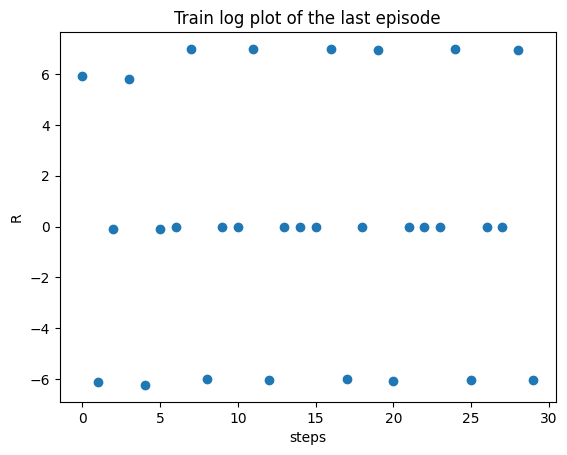

In [30]:
plt.scatter(x = np.arange(len(R_total)), y = R_total)
plt.title("Train log plot of the last episode")
plt.xlabel("steps")
plt.ylabel("R")
plt.show();

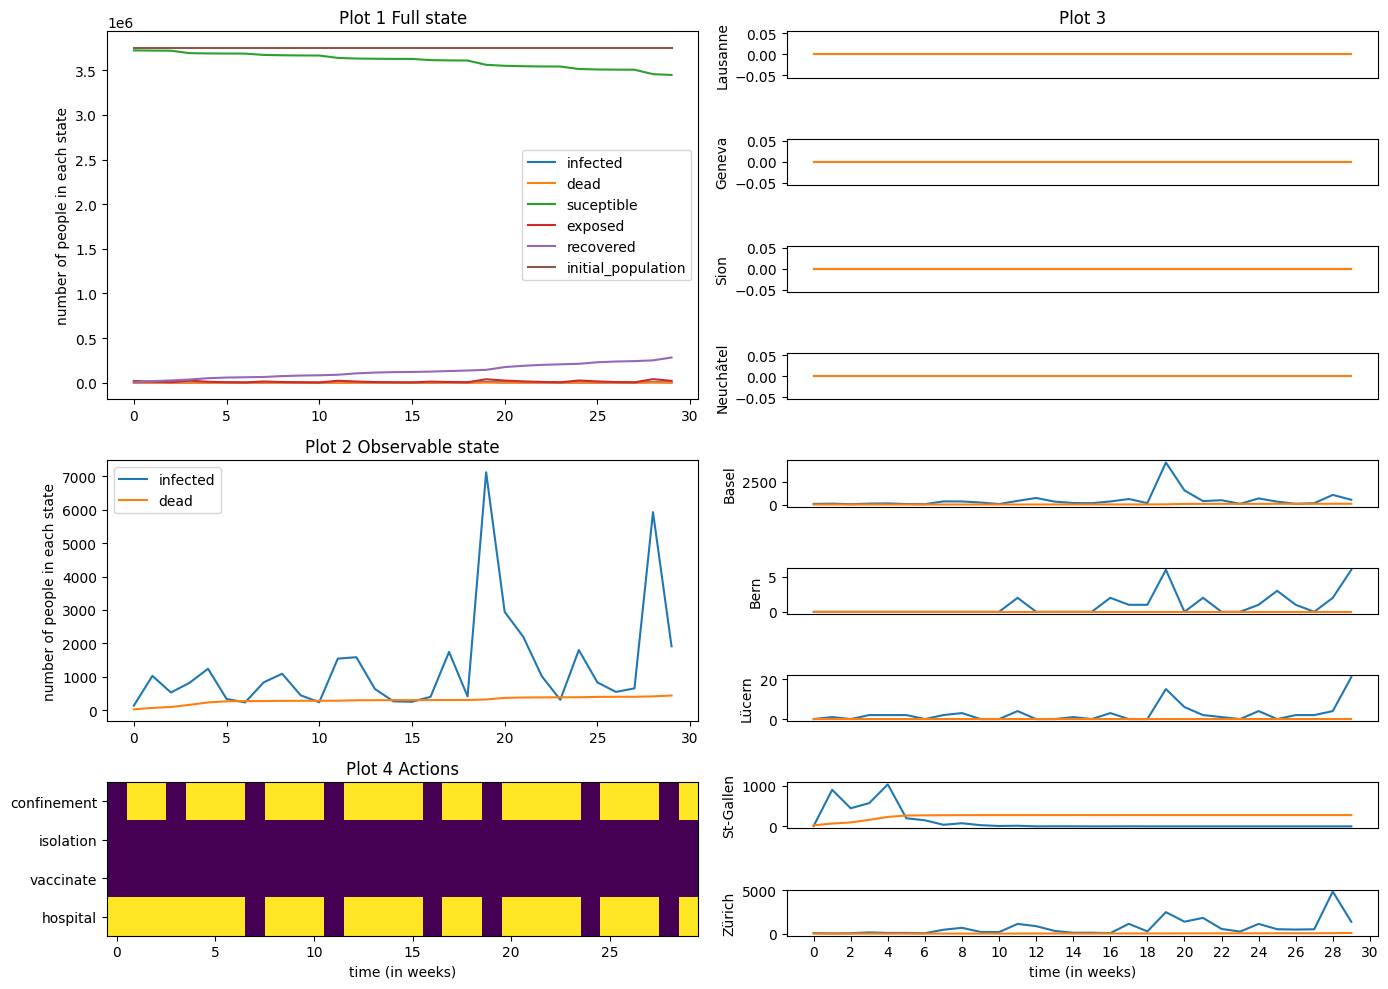

In [31]:
plot_all(leftstate = True, leftobs =True, leftactions = True, right_per_city = True, order = [1, 2, 4, 3])

**Does it successfully learn? Interpret the policy with one of the few episodes of the best policy $\pi^{*}_{factor}$. Is the policy realistic?**

....................................................................................

### Question 4.2.b) multi-action factorized Q-values policy evaluation

Evaluation of the best policy $\pi^{*}_{factor}$ trained in question 4.2.a), using the evaluation procedure that we previously defined. 

*Plot of the histograms is below.*

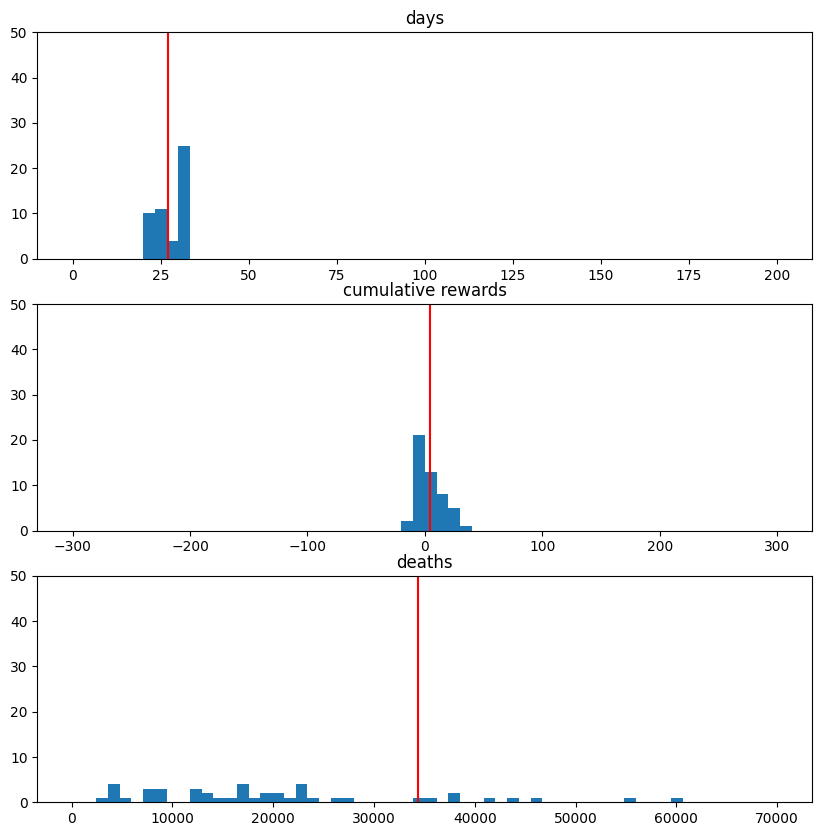

In [32]:
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (100,70000)
    elif title == 'cumulative rewards':
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
def run_experiment(agent, num_episodes):
    fig, ax = plt.subplots(3, 1, figsize=(10,10))
    rewards = []
    confine = []
    death = []
    for trace in range(num_episodes):
        log = []
        seed = trace
        finished = False
        obs, info = env.reset(seed)
        agent.reset()
        n_weeks_confined = 0
        R_sum = 0
        while not finished:
            action = agent.act(obs.flatten().unsqueeze(0), i_episode)
            obs, R, finished, info = env.step(action)
            log.append(info) # save the information dict for logging
            R_sum += R[0][0]
            if 1 in action:
                n_weeks_confined += 1
            if finished:
                break
        """ Parse the logs """
        total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
        confine.append(n_weeks_confined) 
        rewards.append(R_sum)
        death.append(np.sum(total['dead']))
    hist_avg(ax[0], confine, "days")
    hist_avg(ax[1],rewards, "cumulative rewards")
    hist_avg(ax[2],death, "deaths")
    
run_experiment(agent, 50)

**Discuss the results and compare them to the policy implemented in 4.1.b). How does it compare to the toggled policy?**

..............................................................................................

### Question 4.2.c) (Theory) Factorized-Q-values, what assumption does it make?

In question 4.2.a), you implemented a factorized-Q-value policy. What assumptions does the use of such a technique make on the action space? Could you think of an action space for which factorizing Q-values would not be suitable? Discuss.

.........................................................................................

## Wrapping Up

### Question 5.a) (Result analysis) Comparing the training behaviors

Compare the evaluations and training curves of Pr. Russo’s Policy, single-action DQN, factorized Q-values and toggled-action-space policies. Discuss the performance differences, what do you observe? How do the two approaches compare ? What approach performs best? Why?

................................................................

### Question 5.b) (Result analysis) Comparing policies
Run the evaluation procedure with each ($\pi_{DQN}$, $\pi_{toggle}$, $\pi_{factor}$ as well as the original $\pi_{russo}$) trained policy (always pick the best-performing policy) for 50 episode and compute the following metrics (all of the averages are empirical means computed over the 50 episodes):

1. the average number of total confined days avg[$N_{confinement}$] (lower is better),
2. the average number of total isolation days avg[$N_{isolation}$] (lower is better),
3. the average number of total vaccination days avg[$N_{vaccination}$] (lower is better),
4. the average number of total additional hospital bed days avg[$N_{confinement}$] (lower is better),
5. the average number of total deaths avg[$N_{deaths}$] (lower is better),
6. the average cumulative reward avg[$R_{cumulative}$] (higer is better).

Make a table with each of those values for each policy. Clearly mark the best performing policy with respect to
each metric. Exclude the policies that do not have access to an action from the relevant metric (for instance, as
πRusso does not have access to vaccination, exclude it from the total vaccination days comparaison). **Discuss.**

.............................................................................

### Question 5.c) (Interpretability) Q-values
For both $\pi_{DQN}$ and $\pi_{factor}$, produce a plot for visualizing the estimated Q-values for one episode. Run a
simulation episode, and plot a heat-map of the evolution of all Q-values with time, with action selections in the y-axis and time (in weeks) in the x axis. Clearly label which action is associated with which Q-value on the y axis as well as the evolution of time in weeks, provide a color-bar. Discuss your results.**How interpretable is your policy?**

.............................................................


### Question 5.d) (Theory), Is cumulative reward an increasing function of the number of actions?
**In the following project you have implemented different policies acting on the exact same environment with a
different number of actions. Is cumulative reward an increasing function of the number of actions?
(In other words, does adding an action always yield a better reward?)**

........................................................